## BaarleNet [Part 5 - 2x2 tuning]

Semi-fresh start here as I get really going on part 3!

In [1]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import cv2
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
import os

In [2]:
# # Set random seed for reproducibility
# random_seed=25
# torch.manual_seed(random_seed)
# np.random.seed(random_seed)

In [3]:
def denorm(p, size=960):
    result = np.zeros_like(p)
    result[..., 0] = (p[..., 0] + 1) * (size / 2)
    result[..., 1] = size - ((p[..., 1] + 1) * (size / 2))
    return result

def get_relu_joint(weight_1, weight_2, bias, extent=1):
    if np.abs(weight_2) < 1e-8: 
        x_intercept = -bias / weight_1
        return [[x_intercept, -extent], [x_intercept, extent]] if -extent <= x_intercept <= extent else []
    elif np.abs(weight_1) < 1e-8:
        y_intercept = -bias / weight_2
        return [[-extent, y_intercept], [extent, y_intercept]] if -extent <= y_intercept <= extent else []
    else:
        points = []
        for x in [-extent, extent]:
            y = (-x * weight_1 - bias) / weight_2
            if -extent <= y <= extent: points.append([x, y])
        for y in [-extent, extent]:
            x = (-y * weight_2 - bias) / weight_1
            if -extent <= x <= extent: points.append([x, y])
        unique_points = []
        for p in points:
            is_duplicate = False
            for existing in unique_points:
                if abs(p[0] - existing[0]) < 1e-8 and abs(p[1] - existing[1]) < 1e-8:
                    is_duplicate = True
                    break
            if not is_duplicate:
                unique_points.append(p)
        return unique_points

def viz_map_with_predictions(ax, map, X, y):
    probe=np.zeros((100,100,2))
    for j, xx in enumerate(np.linspace(-1, 1, 100)):
        for k, yy in enumerate(np.linspace(-1, 1, 100)):
            probe[j, k]=[yy,xx]
    probe=probe.reshape(100**2, -1)
    probe_logits=model(torch.tensor(probe).float())
    probe_logits=probe_logits.detach().numpy().reshape(100,100,2)
    probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))
    
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(probe_softmax[:,1].reshape(100, 100)), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
    
    X_denorm=denorm(X[:1000,:])
    # plt.scatter(X_denorm[:,0], X_denorm[:,1], c=y[:1000], s=2, alpha=0.8)
    labels=y[:1000]
    y_hat=torch.argmax(model(torch.tensor(X[:1000,:]).float()).detach(),1).numpy()
    tp_mask=np.logical_and(labels==1, y_hat==1)
    fp_mask=np.logical_and(labels==0, y_hat==1)
    fn_mask=np.logical_and(labels==1, y_hat==0)
    tn_mask=np.logical_and(labels==0, y_hat==0)
    ax.scatter(X_denorm[tp_mask,0], X_denorm[tp_mask,1], c='g', s=3, alpha=0.8)
    ax.scatter(X_denorm[fp_mask,0], X_denorm[fp_mask,1], c='r', marker='x', s=5, alpha=0.8)
    ax.scatter(X_denorm[fn_mask,0], X_denorm[fn_mask,1], c='orange', marker='x', s=5, alpha=0.8)
    ax.scatter(X_denorm[tn_mask,0], X_denorm[tn_mask,1], c='purple', marker='o', s=5, alpha=0.8)

In [4]:
def get_second_layer_boundaries(model, extent=1):
    """
    Analytically solve for second layer ReLU boundaries
    Returns list of line segments for each second layer neuron
    """
    
    # Get layer weights and biases
    W1 = model.model[0].weight.detach().numpy()  # Shape: (2, 2)
    b1 = model.model[0].bias.detach().numpy()    # Shape: (2,)
    W2 = model.model[2].weight.detach().numpy()  # Shape: (2, 2) 
    b2 = model.model[2].bias.detach().numpy()    # Shape: (2,)
    
    # First, get the first layer ReLU boundaries
    first_layer_boundaries = []
    for i in range(2):
        boundary = get_relu_joint(W1[i,0], W1[i,1], b1[i], extent)
        first_layer_boundaries.append(boundary)
    
    # Define the regions created by first layer boundaries
    # Each region is defined by which first layer neurons are active
    regions = [
        (False, False),  # Both neurons off
        (True, False),   # First neuron on, second off
        (False, True),   # First neuron off, second on  
        (True, True)     # Both neurons on
    ]
    
    second_layer_boundaries = []
    
    # For each second layer neuron
    for neuron_idx in range(2):
        neuron_boundaries = []
        
        # For each region defined by first layer
        for region_mask in regions:
            # In this region, the second layer pre-activation is:
            # h2_pre = W2[neuron_idx, 0] * (W1[0,:] * x + b1[0]) * region_mask[0] + 
            #          W2[neuron_idx, 1] * (W1[1,:] * x + b1[1]) * region_mask[1] + 
            #          b2[neuron_idx]
            
            # Collect active terms
            active_weight = np.zeros(2)  # Coefficients for [x, y]
            active_bias = b2[neuron_idx]
            
            for i in range(2):
                if region_mask[i]:  # If this first layer neuron is active
                    active_weight += W2[neuron_idx, i] * W1[i, :]
                    active_bias += W2[neuron_idx, i] * b1[i]
            
            # Now solve: active_weight[0] * x + active_weight[1] * y + active_bias = 0
            boundary = get_relu_joint(active_weight[0], active_weight[1], active_bias, extent)
            
            if boundary:
                # Check if this boundary segment is actually within the region
                # We need to verify that the boundary points satisfy the region constraints
                valid_segments = []
                
                for seg_start, seg_end in zip(boundary[:-1], boundary[1:]):
                    # Check if segment is within the region defined by first layer
                    # Sample a point in the middle of the segment
                    mid_point = [(seg_start[0] + seg_end[0])/2, (seg_start[1] + seg_end[1])/2]
                    
                    # Check if this point satisfies the region constraints
                    point_in_region = True
                    for i in range(2):
                        first_layer_activation = W1[i,0] * mid_point[0] + W1[i,1] * mid_point[1] + b1[i]
                        is_active = first_layer_activation > 0
                        if is_active != region_mask[i]:
                            point_in_region = False
                            break
                    
                    if point_in_region:
                        valid_segments.append([seg_start, seg_end])
                
                neuron_boundaries.extend(valid_segments)
        
        second_layer_boundaries.append(neuron_boundaries)
    
    return second_layer_boundaries

def plot_second_layer_boundaries_analytical(ax, model):
    """Plot analytically computed second layer boundaries"""
    
    boundaries = get_second_layer_boundaries(model)
    
    colors = ['red', 'blue']
    for neuron_idx, neuron_boundaries in enumerate(boundaries):
        for segment in neuron_boundaries:
            if len(segment) == 2:  # Valid line segment
                seg_denorm = denorm(np.array(segment))
                ax.plot([seg_denorm[0][0], seg_denorm[1][0]], 
                       [seg_denorm[0][1], seg_denorm[1][1]], 
                       color=colors[neuron_idx], linewidth=2, alpha=0.8,
                       linestyle='dashed', label=f'Layer 2 Neuron {neuron_idx}')

# Simpler version that focuses on the boundary intersections
def get_second_layer_boundaries_simple(model, extent=1):
    """
    Simplified approach: compute boundary in each quadrant defined by first layer
    """
    W1 = model.model[0].weight.detach().numpy()
    b1 = model.model[0].bias.detach().numpy()
    W2 = model.model[2].weight.detach().numpy()
    b2 = model.model[2].bias.detach().numpy()
    
    boundaries = []
    
    # For each second layer neuron
    for neuron_idx in range(2):
        neuron_boundaries = []
        
        # Sample points in a grid and find where the second layer neuron crosses zero
        # But do it analytically by solving the piecewise linear equation
        
        # The key insight: in each region, the equation is linear
        # Region 1: both first layer neurons off
        # h2 = b2[neuron_idx]
        # This gives no boundary unless b2[neuron_idx] = 0
        
        # Region 2: first neuron on, second off  
        # h2 = W2[neuron_idx,0] * (W1[0,0]*x + W1[0,1]*y + b1[0]) + b2[neuron_idx]
        # Set to 0 and solve for the line
        if True:  # Always try this region
            w_eff = W2[neuron_idx, 0] * W1[0, :]
            b_eff = W2[neuron_idx, 0] * b1[0] + b2[neuron_idx]
            boundary = get_relu_joint(w_eff[0], w_eff[1], b_eff, extent)
            if boundary:
                neuron_boundaries.append(boundary)
        
        # Region 3: first neuron off, second on
        if True:
            w_eff = W2[neuron_idx, 1] * W1[1, :]
            b_eff = W2[neuron_idx, 1] * b1[1] + b2[neuron_idx]
            boundary = get_relu_joint(w_eff[0], w_eff[1], b_eff, extent)
            if boundary:
                neuron_boundaries.append(boundary)
        
        # Region 4: both neurons on
        if True:
            w_eff = W2[neuron_idx, 0] * W1[0, :] + W2[neuron_idx, 1] * W1[1, :]
            b_eff = W2[neuron_idx, 0] * b1[0] + W2[neuron_idx, 1] * b1[1] + b2[neuron_idx]
            boundary = get_relu_joint(w_eff[0], w_eff[1], b_eff, extent)
            if boundary:
                neuron_boundaries.append(boundary)
        
        boundaries.append(neuron_boundaries)
    
    return boundaries

# Usage:
def plot_all_boundaries(ax, model):
    """Plot both first and second layer boundaries"""
    
    # First layer (solid lines)
    for neuron_idx in range(2):
        w1 = model.model[0].weight[neuron_idx, 0].item()
        w2 = model.model[0].weight[neuron_idx, 1].item()
        b = model.model[0].bias[neuron_idx].item()
        
        joint = get_relu_joint(w1, w2, b, extent=1)
        if joint:
            joint_denorm = denorm(np.array(joint))
            ax.plot([joint_denorm[0][0], joint_denorm[1][0]], 
                   [joint_denorm[0][1], joint_denorm[1][1]], 
                   color=f'C{neuron_idx}', linewidth=2, alpha=0.8,
                   label=f'Layer 1 Neuron {neuron_idx}')
    
    # Second layer (dashed lines)
    plot_second_layer_boundaries_analytical(ax, model)

In [5]:
map=cv2.imread('Baarle-Nassau_-_Baarle-Hertog-en.svg.png')[:,:,(2,1,0)]

belgium_color=np.array([251,234,81])
netherlands_color=np.array([255, 255, 228])

netherlands_region=((map-netherlands_color)**2).sum(-1)<10
belgium_region=((map-belgium_color)**2).sum(-1)<10000

num_points_to_sample=10000 #10000

b_coords=np.array(np.where(belgium_region)).T.astype('float')
n_coords=np.array(np.where(netherlands_region)).T.astype('float')

#flip and normalize
belgium_coords_all=np.zeros_like(b_coords)
netherlands_coords_all=np.zeros_like(n_coords)

belgium_coords_all[:,0]=b_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
belgium_coords_all[:,1]=(960-b_coords[:,0])/(960/2)-1
netherlands_coords_all[:,0]=n_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
netherlands_coords_all[:,1]=(960-n_coords[:,0])/(960/2)-1

## Hmm to balance to classes or do more area proportional? Not sure yet. 
belgium_coords=belgium_coords_all[np.random.choice(len(belgium_coords_all), num_points_to_sample), :]
netherlands_coords=netherlands_coords_all[np.random.choice(len(netherlands_coords_all), num_points_to_sample), :]

X=np.vstack((netherlands_coords, belgium_coords))
y=np.concatenate((np.zeros(len(netherlands_coords)), np.ones(len(belgium_coords)))).astype('int')

rI=np.arange(len(y))
np.random.shuffle(rI)
X=X[rI,:]
y=y[rI]

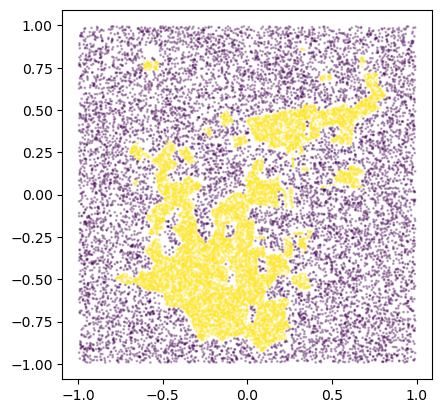

In [6]:
plt.scatter(X[:,0], X[:,1], c=y, s=1, alpha=0.3); plt.axis('square');

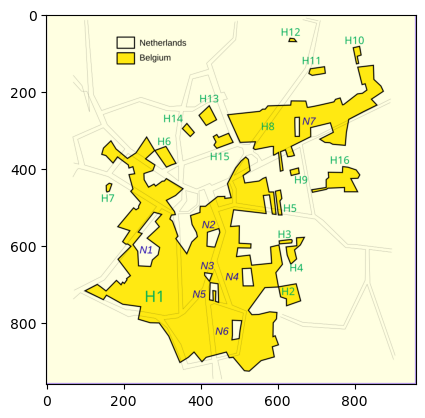

In [7]:
plt.imshow(map)

In [8]:
class BaarleNet(nn.Module):
    def __init__(self, hidden_layers=[64]):
        super(BaarleNet, self).__init__()
        layers = [nn.Linear(2, hidden_layers[0]), nn.ReLU()]
        for i in range(len(hidden_layers)-1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_layers[-1], 2))
        self.layers=layers
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [9]:
# class BaarleNetNoRelu(nn.Module):
#     def __init__(self, hidden_layers=[64]):
#         super(BaarleNet, self).__init__()
#         layers = [nn.Linear(2, hidden_layers[0])] #, nn.ReLU()]
#         for i in range(len(hidden_layers)-1):
#             layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
#             # layers.append(nn.ReLU())
#         layers.append(nn.Linear(hidden_layers[-1], 2))
#         self.layers=layers
#         self.model = nn.Sequential(*layers)
    
#     def forward(self, x):
#         return self.model(x)

In [10]:
## With LayerNorm!

# class BaarleNet(nn.Module):
#     def __init__(self, hidden_layers=[64]):
#         super(BaarleNet, self).__init__()
#         layers = [nn.Linear(2, hidden_layers[0]), nn.LayerNorm(hidden_layers[0]), nn.ReLU()]
        
#         for i in range(len(hidden_layers)-1):
#             layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
#             layers.append(nn.LayerNorm(hidden_layers[i+1]))
#             layers.append(nn.ReLU())
        
#         layers.append(nn.Linear(hidden_layers[-1], 2))
#         self.layers = layers
#         self.model = nn.Sequential(*layers)
    
#     def forward(self, x):
#         return self.model(x)

In [11]:
save_dir='may_20_2'
os.makedirs(save_dir, exist_ok=True)

In [12]:
X.shape

(20000, 2)

- BaarleNet([16, 16, 16, 16]), num_epochs = 10000, batch, Accuracy: 0.9546
- BaarleNet([16, 16, 16, 16]), num_epochs = 10000, stochastic, Accuracy: 0.8749
- BaarleNet([64, 64, 64, 64]), num_epochs = 10000, batch, Accuracy: 0.9810 <- starts to get some nice fine structure

In [13]:
random_seed=0 #Random seed of 3 makes for a nice "fold down the edges" deal, wait that's for 2x2
torch.manual_seed(random_seed)  

X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Initialize model and optimizer
model = BaarleNet([2])
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.25)
optimizer = optim.Adam(model.parameters(), lr=0.01) #0.005

num_epochs = 2500
for epoch in range(num_epochs):
    # Batch
    # outputs = model(X_tensor)
    # loss = criterion(outputs, y_tensor)

    #Stochastic
    outputs = model(torch.tensor(X[epoch%len(y)]).float())
    loss = criterion(outputs, torch.tensor(y[epoch%len(y)])) 

    #Worth trying minibatch?
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()

    # if epoch==307: break #Stop early here so weights don't get updated before we poke around
    
    optimizer.step()
    if (epoch+1) % (num_epochs//25) == 0:
        outputs_batch = model(X_tensor)
        accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')


Epoch [100/2500], Loss: 0.6900, Accuracy: 0.6256
Epoch [200/2500], Loss: 0.6799, Accuracy: 0.6566
Epoch [300/2500], Loss: 0.4754, Accuracy: 0.6518
Epoch [400/2500], Loss: 0.8790, Accuracy: 0.6484
Epoch [500/2500], Loss: 0.4608, Accuracy: 0.6133
Epoch [600/2500], Loss: 0.3864, Accuracy: 0.6464
Epoch [700/2500], Loss: 0.1439, Accuracy: 0.6086
Epoch [800/2500], Loss: 1.0267, Accuracy: 0.6444
Epoch [900/2500], Loss: 0.9577, Accuracy: 0.6576
Epoch [1000/2500], Loss: 0.8529, Accuracy: 0.6644
Epoch [1100/2500], Loss: 1.1944, Accuracy: 0.6775
Epoch [1200/2500], Loss: 0.5351, Accuracy: 0.6115
Epoch [1300/2500], Loss: 0.6947, Accuracy: 0.7190
Epoch [1400/2500], Loss: 0.7956, Accuracy: 0.6933
Epoch [1500/2500], Loss: 1.0475, Accuracy: 0.6459
Epoch [1600/2500], Loss: 0.0734, Accuracy: 0.6874
Epoch [1700/2500], Loss: 1.0587, Accuracy: 0.6996
Epoch [1800/2500], Loss: 0.4483, Accuracy: 0.6693
Epoch [1900/2500], Loss: 0.4439, Accuracy: 0.6944
Epoch [2000/2500], Loss: 0.1425, Accuracy: 0.6655
Epoch [21

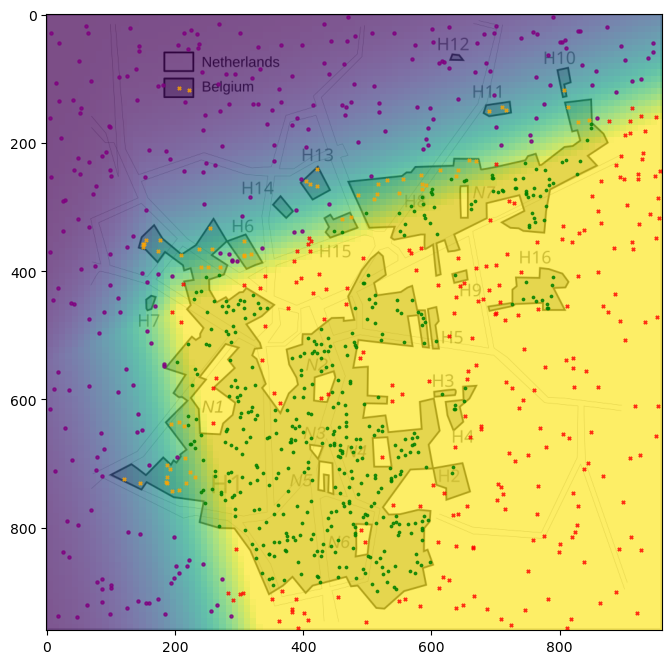

In [14]:
fig=plt.figure(0,(8,8))
ax=fig.add_subplot(111)
viz_map_with_predictions(ax, map, X, y)

- Ok ok ok ok ok ok ok ok ok ok ok ok yeah, how do I want to visualize what's happening here? 
- Oh wait, I'm potentially missing a step of not having ReLus...ok yeah that's straigthforward
- Ok ok ok so I'll need to noodle a bit here to land on the viz technique I want here
- I definitely want it to be really clear what the ReLu is doing!
- "Why does it make sense to kink our planes" lol
- I think that I want to try some kinda 3d plane-ish explanation first, and then fall back to the affine 2 transformation approach
- Why our planes need kinks in them...
- Hmm well when we get to the ReLu, I think the interesting framing will be something like -> can you model "fold up" all the belgium regions while folding down all the netherlands regions...
- Hmm yeah composing of planes vs what exactly...
- Ok not totally sure how I want to handle this yet -> it's like clearer if the final layers decision boundarys are horizontal...how "not horizontal" are they right now I wonder? Let me poke at this and see what I can figure out.
- Hmm there's no activation function in the second layer - does that help me at all?

In [15]:
probe=np.zeros((100,100,2))
for j, xx in enumerate(np.linspace(-1, 1, 100)):
    for k, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[j, k]=[yy,xx]
probe=probe.reshape(100**2, -1)

In [16]:
h1 = model.model[:2](torch.tensor(probe).float())
h1 = h1.detach().numpy().reshape(100,100,2)

# First neuron (output index 0)
j1 = get_relu_joint(model.model[0].weight[0,0].item(), model.model[0].weight[0,1].item(), model.model[0].bias[0].item(), extent=1)
j1 = denorm(np.array(j1)) if j1 else []

# Second neuron (output index 1)  
j2 = get_relu_joint(model.model[0].weight[1,0].item(), model.model[0].weight[1,1].item(), model.model[0].bias[1].item(), extent=1)
j2 = denorm(np.array(j2)) if j2 else []

In [17]:
j1

array([[  0.        , 541.32672151],
       [960.        , 165.49347973]])

In [18]:
j2

array([[332.95999865, 960.        ],
       [ 84.50388142,   0.        ]])

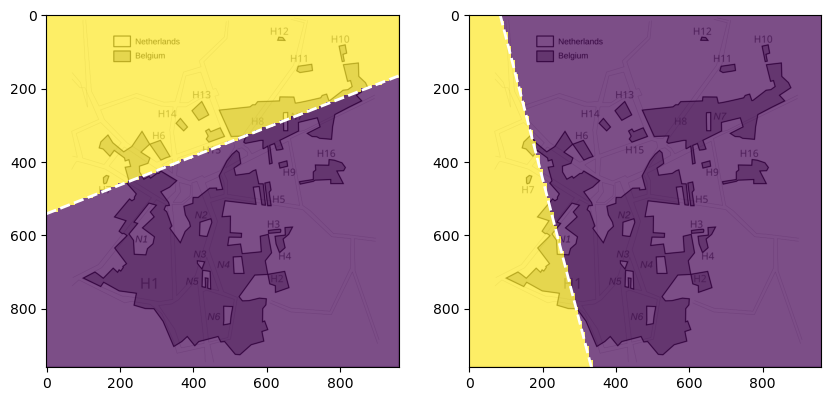

In [19]:
fig=plt.figure(0,(10,5)); 
for i in range(2):
    ax=fig.add_subplot(1,2,i+1)
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(h1[:,:,i]>0), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
    if i==0: ax.plot([j1[0][0], j1[1][0]], [j1[0][1], j1[1][1]], '--', color='#FFFFFF', linewidth=2)
    if i==1: ax.plot([j2[0][0], j2[1][0]], [j2[0][1], j2[1][1]], '--', color='#FFFFFF', linewidth=2)

- Ok, that's pretty cool
- Now, how to show and think about composition.
- Stacking scaled ReLu planes lets go!!!

In [20]:
h2 = model.model[:3](torch.tensor(probe).float())
h2 = h2.detach().numpy().reshape(100,100,2)

In [21]:
h2.shape

(100, 100, 2)

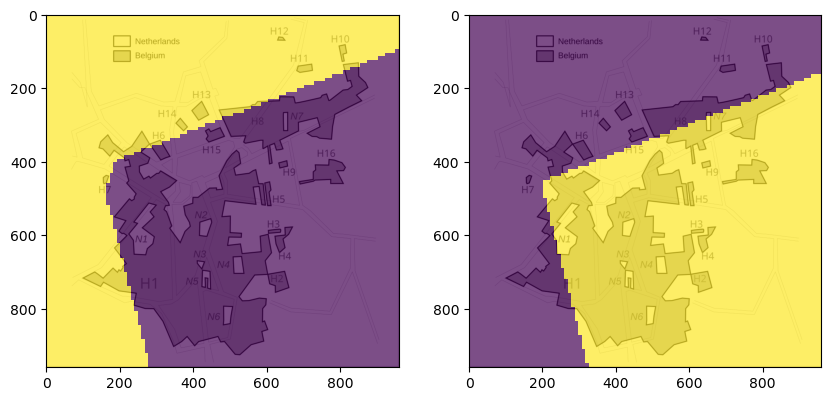

In [22]:
fig=plt.figure(0,(10,5)); 
for i in range(2):
    ax=fig.add_subplot(1,2,i+1)
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(h2[:,:,i]>0), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')

In [26]:
model.model[0].weight.detach().numpy()

array([[-0.70856154,  1.809896  ],
       [-1.7940422 , -0.4643133 ]], dtype=float32)

In [28]:
model.model[0].bias.detach().numpy()

array([-0.47732198, -1.0138882 ], dtype=float32)

In [29]:
model.model[2].weight.detach().numpy()

array([[ 1.5246898,  2.049856 ],
       [-1.6014509, -1.3020881]], dtype=float32)

In [30]:
model.model[2].bias.detach().numpy()

array([-0.40461758,  0.05192775], dtype=float32)

In [33]:
model.model[0].weight.detach().numpy()
array([[-0.70856154,  1.809896  ],
       [-1.7940422 , -0.4643133 ]], dtype=float32)
model.model[0].bias.detach().numpy()
array([-0.47732198, -1.0138882 ], dtype=float32)
model.model[2].weight.detach().numpy()
array([[ 1.5246898,  2.049856 ],
       [-1.6014509, -1.3020881]], dtype=float32)
model.model[2].bias.detach().numpy()
array([-0.40461758,  0.05192775], dtype=float32)

w1=np.array([[-0.70856154,  1.809896  ],
       [-1.7940422 , -0.4643133 ]], dtype=np.float32)
b1=np.array([-0.47732198, -1.0138882 ], dtype=np.float32)
w2=np.array([[ 1.5246898,  2.049856 ],
       [-1.6014509, -1.3020881]], dtype=np.float32)
b2=np.array([-0.40461758,  0.05192775], dtype=np.float32)

NameError: name 'array' is not defined

---

## 2 hidden layers - how do figure out where all the ReLu joints are?

In [37]:
# for random_seed in range(1000): 
#     torch.manual_seed(random_seed)  

#     X_tensor = torch.FloatTensor(X)
#     y_tensor = torch.tensor(y)
    
#     # Initialize model and optimizer
#     model = BaarleNet([2,2])
#     criterion = nn.CrossEntropyLoss()
#     # optimizer = optim.SGD(model.parameters(), lr=0.25)
#     optimizer = optim.Adam(model.parameters(), lr=0.003) #0.005
    
#     num_epochs = 8000
#     for epoch in range(num_epochs):
#         # Batch
#         # outputs = model(X_tensor)
#         # loss = criterion(outputs, y_tensor)
    
#         #Stochastic
#         outputs = model(torch.tensor(X[epoch%len(y)]).float())
#         loss = criterion(outputs, torch.tensor(y[epoch%len(y)])) 
    
#         #Worth trying minibatch?
        
#         # Backward and optimize
#         optimizer.zero_grad()
#         loss.backward()
    
#         # if epoch==307: break #Stop early here so weights don't get updated before we poke around
        
#         optimizer.step()

#     outputs_batch = model(X_tensor)
#     accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)
#     if accuracy>0.7:
#         print(f'Random Seed = {random_seed}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')

In [31]:
#5 is the first one that looks kinda interesting, 8 is a little more interesting, 11 is kinda cool.
# random_seed=96
# random_seed=18 
# random_seed=19
# random_seed=26
# random_seed=32
# random_seed=40
# random_seed=48
# random_seed=57
# random_seed=71
# random_seed=78

# random_seed=870
# random_seed=958
random_seed=315


torch.manual_seed(random_seed)  

X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Initialize model and optimizer
model = BaarleNet([2,2])
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.25)
optimizer = optim.Adam(model.parameters(), lr=0.0025) #0.005

num_epochs = 8000
for epoch in range(num_epochs):
    # Batch
    # outputs = model(X_tensor)
    # loss = criterion(outputs, y_tensor)

    #Stochastic
    outputs = model(torch.tensor(X[epoch%len(y)]).float())
    loss = criterion(outputs, torch.tensor(y[epoch%len(y)])) 

    #Worth trying minibatch?
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()

    # if epoch==307: break #Stop early here so weights don't get updated before we poke around
    
    optimizer.step()
    if (epoch+1) % (num_epochs//10) == 0:
        outputs_batch = model(X_tensor)
        accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')


Epoch [800/8000], Loss: 0.5973, Accuracy: 0.5000
Epoch [1600/8000], Loss: 0.7116, Accuracy: 0.6230
Epoch [2400/8000], Loss: 0.7140, Accuracy: 0.7320
Epoch [3200/8000], Loss: 0.8080, Accuracy: 0.8097
Epoch [4000/8000], Loss: 0.7786, Accuracy: 0.8118
Epoch [4800/8000], Loss: 0.7101, Accuracy: 0.8076
Epoch [5600/8000], Loss: 0.2879, Accuracy: 0.8135
Epoch [6400/8000], Loss: 0.2990, Accuracy: 0.8322
Epoch [7200/8000], Loss: 0.0033, Accuracy: 0.8176
Epoch [8000/8000], Loss: 0.0424, Accuracy: 0.8328


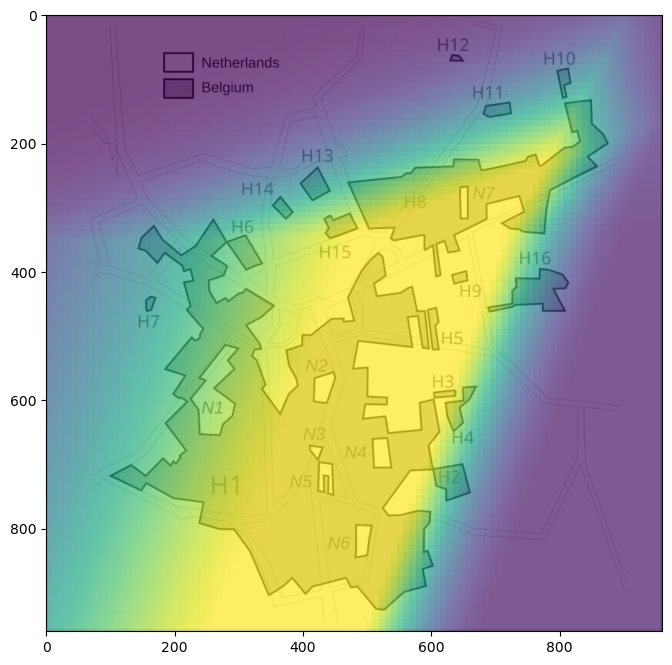

In [32]:
fig=plt.figure(0,(8,8))
ax=fig.add_subplot(111)

probe=np.zeros((100,100,2))
for j, xx in enumerate(np.linspace(-1, 1, 100)):
    for k, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[j, k]=[yy,xx]
probe=probe.reshape(100**2, -1)
probe_logits=model(torch.tensor(probe).float())
probe_logits=probe_logits.detach().numpy().reshape(100,100,2)
probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))

ax.imshow(map.mean(2), cmap='gray')
ax.imshow(np.flipud(probe_softmax[:,1].reshape(100, 100)), 
          # np.flipud(probe_logits[:,1]), 
           extent=[0, 960, 960, 0],  # This maps to image coordinates
           alpha=0.7,
           cmap='viridis')

In [33]:
h1 = model.model[:2](torch.tensor(probe).float())
h1 = h1.detach().numpy().reshape(100,100,2)

# First neuron (output index 0)
j1 = get_relu_joint(model.model[0].weight[0,0].item(), model.model[0].weight[0,1].item(), model.model[0].bias[0].item(), extent=1)
j1 = denorm(np.array(j1)) if j1 else []

# Second neuron (output index 1)  
j2 = get_relu_joint(model.model[0].weight[1,0].item(), model.model[0].weight[1,1].item(), model.model[0].bias[1].item(), extent=1)
j2 = denorm(np.array(j2)) if j2 else []

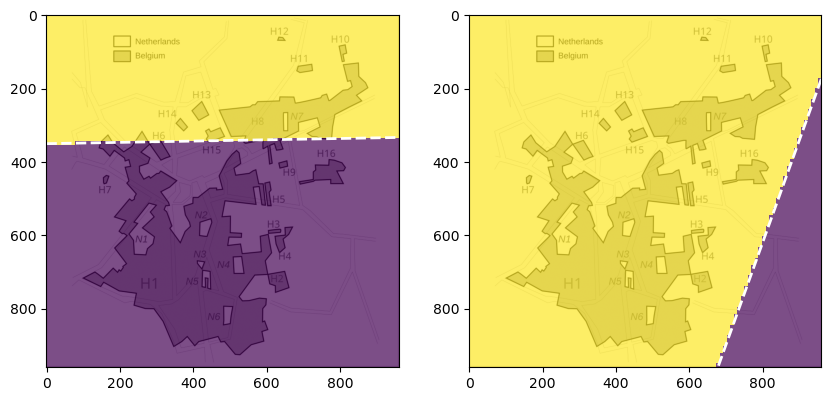

In [34]:
fig=plt.figure(0,(10,5)); 
for i in range(2):
    ax=fig.add_subplot(1,2,i+1)
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(h1[:,:,i]>0), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
    if i==0: ax.plot([j1[0][0], j1[1][0]], [j1[0][1], j1[1][1]], '--', color='#FFFFFF', linewidth=2)
    if i==1: ax.plot([j2[0][0], j2[1][0]], [j2[0][1], j2[1][1]], '--', color='#FFFFFF', linewidth=2)

In [35]:
h2 = model.model[:4](torch.tensor(probe).float())
h2 = h2.detach().numpy().reshape(100,100,2)

# First neuron (output index 0)
# j1 = get_relu_joint(model.model[0].weight[0,0].item(), model.model[0].weight[0,1].item(), model.model[0].bias[0].item(), extent=1)
# j1 = denorm(np.array(j1)) if j1 else []

# # Second neuron (output index 1)  
# j2 = get_relu_joint(model.model[0].weight[1,0].item(), model.model[0].weight[1,1].item(), model.model[0].bias[1].item(), extent=1)
# j2 = denorm(np.array(j2)) if j2 else []

/tmp/ipykernel_27663/173710381.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  x_intercept = -bias / weight_1


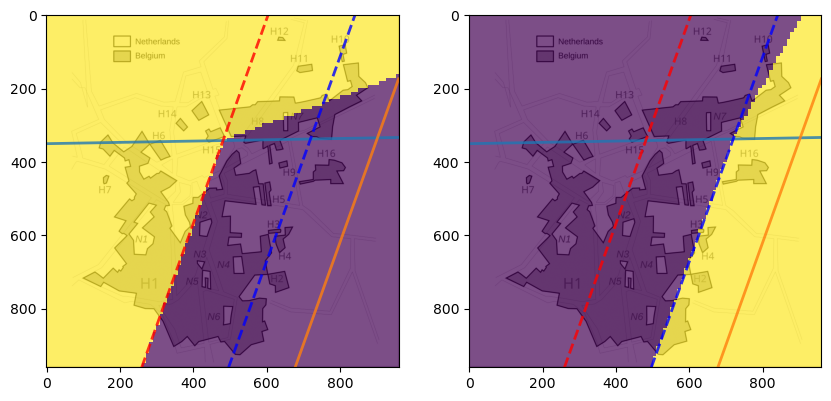

In [48]:
fig=plt.figure(0,(10,5)); 
for i in range(2):
    ax=fig.add_subplot(1,2,i+1)
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(h2[:,:,i]>0), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
    
    # if i==0: ax.plot([j1[0][0], j1[1][0]], [j1[0][1], j1[1][1]], '--', color='#FFFFFF', linewidth=2)
    # if i==1: ax.plot([j2[0][0], j2[1][0]], [j2[0][1], j2[1][1]], '--', color='#FFFFFF', linewidth=2)
    plot_all_boundaries(ax, model)

- Ok, so 315 is nice - definitely keep to understand what's happening geometrically- it still feels like something i could do with a single hidden layer with 4 hidden units? let me get some Relu boundaries on there next!
- Ok can't tell how much sense these claude generated boundaries make just yet -> let me keep moving for a bit though.

In [49]:
logits = model.model(torch.tensor(probe).float())
logits = logits.detach().numpy().reshape(100,100,2)

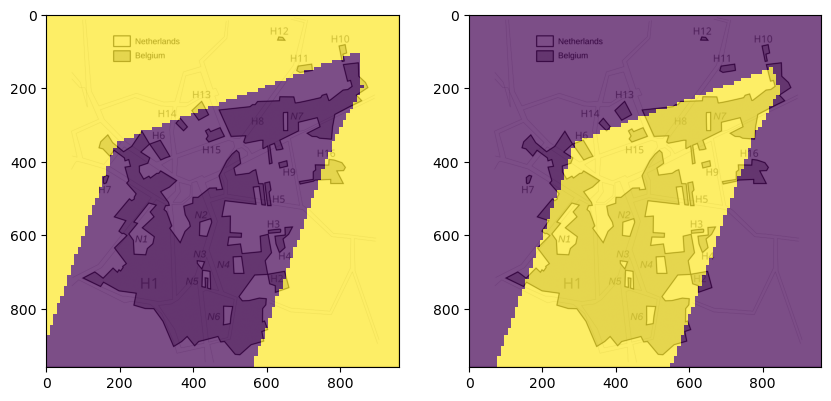

In [52]:
fig=plt.figure(0,(10,5)); 
for i in range(2):
    ax=fig.add_subplot(1,2,i+1)
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(logits[:,:,i]>0), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')

- Ok nice, I think i see 5 boundaries here, but one is kind subtle -> maybe I can accentuate it somehow?
- Let's say it's fine for now.
- Ok so, I do think that the 3d fold-y-ish version of this is really important, let me take this example, and go hack in on this geometry -> if there's a nice animation/intuitive way to show why these borders show up where they do, then I feel like (aside from higher dimensional stuff), that animation will really be a key intellectual satisfaction payoff moment of the pice

In [70]:
model.model[4].weight.detach().numpy()

array([[ 1.8897862,  3.0432484],
       [-1.7220999, -2.2057745]], dtype=float32)

In [71]:
model.model[4].bias.detach().numpy()

array([-1.0249746 ,  0.61326534], dtype=float32)

In [74]:
w1=np.array([[-0.02866297,  1.6250265 ],
             [-1.3056537 ,  0.46831134]], dtype=np.float32)
b1=np.array([-0.4677289,  1.0067637], dtype=np.float32)

w2=np.array([[ 1.3398709 ,  0.68694556],
             [-0.29886743, -1.8411286 ]], dtype=np.float32)
b2=np.array([-0.7817721 ,  0.90856946], dtype=np.float32)

w3=np.array([[ 1.8897862,  3.0432484],
             [-1.7220999, -2.2057745]], dtype=np.float32)
b3=np.array([-1.0249746 ,  0.61326534], dtype=np.float32)

In [29]:
model.model

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2, out_features=2, bias=True)
  (3): ReLU()
  (4): Linear(in_features=2, out_features=2, bias=True)
)

---

- Multiply the height value (and only the height value) of the first plane or relu plane by 1.6995 and add the second plane multiplied by 2.1654, add the results together
- What does it look like gometrically to mutiply each jointed plane by some number and then add -> hey are we just adding scaled versions of these planes together.
- Hmm there's maybe an interseting "collapsing city points onto a line" angle to it.
- Ok, now adding scale versions of our plane together feels pretty chill. they can be negative too.
- Is that what's happening, or am I missing something
- Ok ok ok, so I feel like we're just stacking scaled relu planes? Is that not what's going on here? Hmm yeah and when you stack em the decision boundaries can stack up in interesting ways? They can be flipped too. 
- I feel like an important/interesting thing here will be way ramping up the number of neurons in the single hidden layer
- Yeah i really feel that I can do the whole thing with just plane height?
- Oh man I geuess we can do training animations too?
- I'm super fuzzy on how this maps to multiple hidden layers